In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!git clone https://github.com/JingyunLiang/SwinIR.git
%cd SwinIR
!pip install basicsr timm


Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 333 (delta 6), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (333/333), 29.84 MiB | 43.65 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/SwinIR
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none

In [ ]:
import sys
import torch
from models.network_swinir import SwinIR
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
sys.path.append('./')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
import torch.nn.functional as F

def edges(x):#sobel edges

    Gx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32).view(1,1,3,3).to(x.device)
    Gy = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32).view(1,1,3,3).to(x.device)

    edge_x = F.conv2d(x, Gx, padding=1, groups=1)
    edge_y = F.conv2d(x, Gy, padding=1, groups=1)
    return torch.sqrt(edge_x ** 2 + edge_y ** 2)


In [ ]:
from models.network_swinir import SwinIR

swinir_model = SwinIR(
    upscale=4,
    in_chans=3,
    img_size=64,
    window_size=8,
    img_range=1.0,
    depths=[6, 6, 6, 6, 6, 6],
    embed_dim=180,
    num_heads=[6, 6, 6, 6, 6, 6],
    mlp_ratio=2,
    upsampler='pixelshuffle',
    resi_connection='1conv'
).to(device)


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
import torch
weight_path = '/content/drive/MyDrive/archive/model/swinDIVK.pth'
raw_state = torch.load(weight_path, map_location=device)
state_dict = raw_state['params'] if 'params' in raw_state else raw_state
filtered_state_dict = {
    k: v for k, v in state_dict.items() if not k.endswith('attn_mask')
}
swinir_model.load_state_dict(filtered_state_dict, strict=False)
swinir_model.eval()
print("Model loaded from drive with attn_mask.")


Model loaded from drive with attn_mask.


Saving 0064x2.png to 0064x2.png


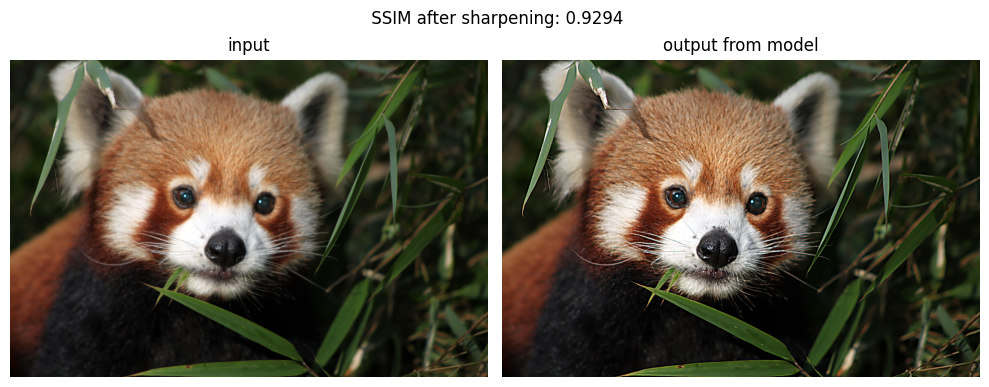

In [ ]:
from PIL import Image, ImageFilter
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

original = Image.open(img_path).convert("RGB")
sharpened = original.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
orig_np = np.array(original).astype(np.float32) / 255.0
sharp_np = np.array(sharpened).astype(np.float32) / 255.0
ssim_val = compare_ssim(orig_np, sharp_np, channel_axis=2, data_range=1.0)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(original)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("output from model")
plt.imshow(sharpened)
plt.axis("off")
plt.suptitle(f" SSIM after sharpening: {ssim_val:.4f}", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
torch.save(swinir_model.state_dict(), '/content/drive/MyDrive/archive/teacher/teacher.pth')

teacher done

In [ ]:
import torch
from models.network_swinir import SwinIR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

swinir_model = SwinIR(
    upscale=4, img_size=64, window_size=8,
    depths=[6, 6, 6, 6, 6, 6], embed_dim=180,
    num_heads=[6, 6, 6, 6, 6, 6], mlp_ratio=2,
    upsampler='pixelshuffle', resi_connection='1conv'
).to(device)

weights = '/content/drive/MyDrive/archive/teacher/teacher.pth'
swinir_model.load_state_dict(torch.load(weights, map_location=device))
swinir_model.eval()

print("teacher model loaded from google drive")

teacher model loaded from google drive


train

In [ ]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import os
from tqdm import tqdm
from models.network_swinir import SwinIR

sys.path.append('./')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import torch
import torch.nn as nn

class IMDModule(nn.Module):
    def __init__(self, in_channels, distillation_rate=0.25):
        super(IMDModule, self).__init__()
        d = int(in_channels * distillation_rate)
        r = in_channels - d

        self.c1 = nn.Conv2d(in_channels, in_channels, 3, 1, 1)
        self.act = nn.LeakyReLU(0.05, inplace=True)

        self.distill = nn.Conv2d(d, d, 3, 1, 1)
        self.remaining = nn.Conv2d(r, r, 3, 1, 1)

        self.fuse = nn.Conv2d(in_channels, in_channels, 1, 1, 0)

    def forward(self, x):
        x1 = self.act(self.c1(x))
        d, r = torch.split(x1, [int(x1.shape[1] * 0.25), int(x1.shape[1] * 0.75)], dim=1)
        d = self.act(self.distill(d))
        r = self.act(self.remaining(r))
        out = torch.cat([d, r], dim=1)
        out = self.fuse(out)
        return out + x


class IMDN(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nf=64, num_modules=6, scale=1):
        super(IMDN, self).__init__()
        self.scale = scale
        self.fea_conv = nn.Conv2d(in_channels, nf, 3, 1, 1)

        self.blocks = nn.Sequential(
            *[IMDModule(nf) for _ in range(num_modules)]
        )
        self.lr_conv = nn.Conv2d(nf, nf, 3, 1, 1)
        self.upsampler = nn.Identity() if scale == 1 else nn.Sequential(
            nn.Conv2d(nf, out_channels * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale)
        )
        self.hr_conv = nn.Conv2d(nf, out_channels, 3, 1, 1)

    def forward(self, x):
        fea = self.fea_conv(x)
        out = self.blocks(fea)
        out = self.lr_conv(out) + fea
        out = self.hr_conv(out)
        out = self.upsampler(out)
        return out


In [ ]:
teacher = SwinIR(
    upscale=2,
    in_chans=3,
    img_size=64,
    window_size=8,
    img_range=1.,
    depths=[6, 6, 6, 6, 6, 6],
    embed_dim=180,
    num_heads=[6, 6, 6, 6, 6, 6],
    mlp_ratio=2,
    upsampler='pixelshuffle',
    resi_connection='1conv'
)


In [ ]:
student = IMDN().to(device)

In [ ]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

class DIV2KDataset(torch.utils.data.Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_paths = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)])
        self.hr_paths = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)])

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = transform(Image.open(self.lr_paths[idx]).convert('RGB'))
        hr = transform(Image.open(self.hr_paths[idx]).convert('RGB'))
        return lr, hr

train_dataset = DIV2KDataset('/content/drive/MyDrive/archive/DATASET/dataset_root2/lr2',
                             '/content/drive/MyDrive/archive/DATASET/dataset_root2/hr2')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from PIL import Image
sys.path.append('./SwinIR')
from models.network_swinir import SwinIR
import matplotlib.pyplot as plt

In [ ]:
class DIV2KDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_paths = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)])
        self.hr_paths = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)])
        self.transform = T.Compose([
            T.Resize((64, 64)),
            T.ToTensor()
        ])
        self.hr_transform = T.Compose([
            T.Resize((128, 128)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = self.transform(Image.open(self.lr_paths[idx]).convert('RGB'))
        hr = self.hr_transform(Image.open(self.hr_paths[idx]).convert('RGB'))
        return lr, hr

In [ ]:
class IMDModule(nn.Module):
    def __init__(self, in_channels, distillation_rate=0.25):
        super(IMDModule, self).__init__()
        c = in_channels
        d = int(c * distillation_rate)
        r = c - d
        self.c1 = nn.Conv2d(c, c, 3, 1, 1)
        self.act = nn.LeakyReLU(0.05, inplace=True)
        self.c2 = nn.Conv2d(r, c, 3, 1, 1)
        self.fuse = nn.Conv2d(c + d, c, 1, 1, 0)
        self.d = d
        self.r = r

    def forward(self, x):
        out = self.act(self.c1(x))
        distilled, remaining = torch.split(out, [self.d, self.r], dim=1)
        out = self.act(self.c2(remaining))
        out = self.fuse(torch.cat([distilled, out], dim=1))
        return out + x

class IMDN(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nf=64, num_modules=6, scale=2):
        super(IMDN, self).__init__()
        self.fea_conv = nn.Conv2d(in_channels, nf, 3, 1, 1)
        self.blocks = nn.Sequential(*[IMDModule(nf) for _ in range(num_modules)])
        self.lr_conv = nn.Conv2d(nf, nf, 3, 1, 1)
        self.upsampler = nn.Sequential(
            nn.Conv2d(nf, out_channels * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale)
        )
        self.hr_conv = nn.Conv2d(nf, out_channels, 3, 1, 1)

    def forward(self, x):
        fea = self.fea_conv(x)
        out = self.blocks(fea)
        out = self.lr_conv(out) + fea
        out = self.upsampler(out)
        return out

In [ ]:
train_dataset = DIV2KDataset(
    '/content/drive/MyDrive/archive/DATASET/dataset_root2/lr2',
    '/content/drive/MyDrive/archive/DATASET/dataset_root2/hr2'
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student = IMDN(scale=2).to(device)
teacher = SwinIR(
    upscale=2, in_chans=3, img_size=64, window_size=8, img_range=1.,
    depths=[6, 6, 6, 6, 6, 6], embed_dim=180,
    num_heads=[6, 6, 6, 6, 6, 6], mlp_ratio=2,
    upsampler='pixelshuffle', resi_connection='1conv'
).to(device)

teacher_state_dict = torch.load('/content/drive/MyDrive/archive/teacher/teacher.pth')
filtered_state_dict = {k: v for k, v in teacher_state_dict.items() if k in teacher.state_dict() and teacher.state_dict()[k].shape == v.shape}
teacher.load_state_dict(filtered_state_dict, strict=False)
teacher.to(device).eval()


SwinIR(
  (conv_first): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=180, input_resolution=(64, 64), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=180, input_resolution=(64, 64), num_heads=6, window_size=8, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=180, window_size=(8, 8), num_heads=6
              (qkv): Linear(in_features=180, out_features=540, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=180, out_features=180, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
       

In [ ]:
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)
epochs = 50
save_path = "/content/drive/MyDrive/archive/student2"
os.makedirs(save_path, exist_ok=True)
losses = []

for epoch in range(epochs):
    student.train()
    total_loss = 0.0

    for lr_img, hr_img in train_loader:
        lr_img, hr_img = lr_img.to(device), hr_img.to(device)

        optimizer.zero_grad()
        student_output = student(lr_img)

        with torch.no_grad():
            teacher_output = teacher(lr_img)

        loss_sr = criterion(student_output, hr_img)
        loss_distill = criterion(student_output, teacher_output)
        loss = loss_sr + 0.1 * loss_distill
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")
    torch.save(student.state_dict(), f"{save_path}/student_epoch_{epoch+1}.pth")

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), losses, marker='o', linestyle='-', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
